In [ ]:
import pandas as pd
import glob
import os
import shutil 
from shapely.geometry import Point
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime

# Grid realization

In [ ]:
# Required function that allow to perform nearest neighbor algorythm

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points


In [ ]:
# An example csv is loaded from the reference folder for the creation of the grid, starting from it we define grid's boundaries

csv_file = pd.read_csv('C:/Users/maria/OneDrive - Politecnico di Milano/Desktop/GeoinfoProject/Prova/provadati3.csv')
lon_min = min(csv_file['lon'])
lon_max = max(csv_file['lon'])
lat_min = min(csv_file['lat'])
lat_max = max(csv_file['lat'])

In [ ]:
# The grid is created with a loop, denominators used for computing delta_lat and delta_lon are estabilished through QGIS
grid = pd.DataFrame(columns = ['id_grid','latitude_grid', 'longitude_grid', 'geometry'])
delta_lat = (lat_max - lat_min)/82
delta_lon = (lon_max - lon_min)/101
i = 0

for lon in np.arange(lon_min, lon_max+delta_lon, delta_lon):
    for lat in np.arange(lat_min, lat_max + delta_lat, delta_lat):
        p = Point(lon, lat)
        row = pd.DataFrame([[i, lat, lon, p]], columns = ['id_grid','latitude_grid', 'longitude_grid', 'geometry'])
        grid = grid.append(row)
        i = i + 1

In [ ]:
# 'geometry' column is added in grid (required by nearest neighbor functions)
csv_file['geometry'] = csv_file.apply(lambda _: '', axis=1)

for i in range(len(csv_file)):
    csv_file['geometry'][i] = Point(csv_file['lon'][i], csv_file['lat'][i])

In [ ]:
# Nearest neighbor algorithm is perfrmed between the grid and the CSV take as example
# allow to assign each point of the grid to the closest one in the csv
csv_file['id_csv'] = (csv_file.index).astype(int)
temp_nn = nearest_neighbor(csv_file, grid, return_dist = False)
temp_nn['id_grid'] = temp_nn['id_grid'].astype(int)
temp_nn['id_to_add'] = (temp_nn.index).astype(int)

In [ ]:
# A merge is performed between the dataframe on the IDs in order to assign the quadkeys
temp_nn['id_to_add'] = (temp_nn.index).astype(int)
nn_merge = temp_nn.merge(csv_file, left_on = 'id_to_add', right_on = 'id_csv')
nn_merge_2 = nn_merge[['id_grid','longitude_grid', 'latitude_grid', 'geometry_x', 'quadkey']]
nn_merge_2.to_csv('C:/Users/maria/OneDrive - Politecnico di Milano/Desktop/GeoinfoProject/Controllare/griglia_temp.csv')

# We now have obtained a regular grid, most of the points of the grid has a specific quadkey

# Some points don't have a quadkey beacuse there are missing data in the csv
# missing quadkeys have been added manually through QGIS


# CSV gridding, transformation in NetCDF, metadata realization and upload on ODC

In [ ]:
# The following piece of code check automatically if there are new csv in the reference folder, grid them, transform in
# NetCDF, creates the yaml file and upload the in ODC

In [ ]:
def gridData(csvfiles):
    # definition of the path to necessary folders and files:
    grid_path = 'C:/git/FB_ODC_2021/griglia_csv/GRIGLIA_MILANO.csv'  
    path_to_netcdf_folder = 'C:/git/FB_ODC_2021/netcdf_files'
    origin = 'C:/git/FB_ODC_2021/empty_yaml.yaml'
    # 2) Once having determined the csv to upload we can proceed with the processing of the data
    #    First we need to upload the grid (for further details on grid realization see 'grid.py')
    grid = pd.read_csv(grid_path)
    grid = grid.drop(columns='geometry')
    
    #    All the csv are loaded as pandas dataframe, then are joined to the grid on quadkey 
    gridded_csv = []
    #all_datetimes = []
    for i in range(len(csvfiles)):
        temp_df = pd.read_csv(csvfiles[i])
        # Not necessary columns are dropped
        temp_df = temp_df.drop(columns = ['country','lon', 'lat', 'n_baseline', 'n_difference', 'density_crisis', 'density_baseline', 'percent_change', 'clipped_z_score', 'ds'])
        # nan values are set to 0
        temp_df['n_crisis'] = temp_df['n_crisis'].replace( '\\N', 0)
        temp_df['n_crisis'] = temp_df['n_crisis'].astype(float)
        # merge on the quadkey
        temp_gridded = grid.merge(temp_df, on = 'quadkey', how = 'outer')
        temp_gridded = temp_gridded.rename(columns = {'latitude_g':'latitude', 'longitude_g':'longitude'})
        temp_gridded['n_crisis'].fillna(0, inplace=True)
        temp_gridded.crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
        # all the datetimes are stored in a list that will be uset to name the NETCDF files
        dt_string = (((csvfiles[i].split('_'))[3]).split('.'))[0]  
        dt = datetime.strptime(dt_string, '%Y-%m-%d %H%M')
        #all_datetimes.append(datetime)
        temp_gridded['date_time'] = dt
        #temp_gridded['date_time']  = pd.to_datetime(temp_gridded['date_time'] , format = "%Y-%m-%dT%H:%M:%S")
        temp_gridded = temp_gridded.rename(columns = {'date_time':'time'})
        temp_gridded = temp_gridded[['latitude', 'longitude', 'quadkey', 'n_crisis', 'time']]
        temp_gridded = temp_gridded.drop(columns=['quadkey'])
        temp_gridded = temp_gridded.sort_values(by = ['latitude', 'longitude'], ascending = [False, True])
        temp_gridded = temp_gridded.set_index(['time', 'latitude', 'longitude'])
        # all gridded csv are stored in gridded_csv
        gridded_csv.append(temp_gridded)
        print('ok',i,'gridded')
        temp_xarray = temp_gridded.to_xarray()
        print('ok',i,'to xarray')
        netcdf_path = path_to_netcdf_folder+'/'+dt_string.replace(" ", "") +'.nc'
        temp_xarray.to_netcdf(netcdf_path)
        print('ok',i,'in netcdf')
    
        # REALIZATION OF yaml DATASET
        datetime_string = dt_string[0:10]+"T"+dt_string[11]+dt_string[12]+":"+dt_string[13]+dt_string[14]+":00.000Z"
        PID = list(dt_string)
        PID.remove("-")
        PID.remove("-")
        PID.remove(" ")
        PID = "".join(PID)
        file1 = open(origin, "w")
        to_write = "$schema: https://schemas.opendatacube.org/dataset \n \nid: 00000000-0000-0000-0000-"+PID+"\n\nproduct:\n  name: MILAN\n  href: https://dataforgood.fb.com/ \n  format: NetCDF\n\ncrs: epsg:4326\n\ngeometry:\n  type: Polygon\n  coordinates: [[[ 8.995056152343800, 45.311597470877999], [8.995056152343800, 45.627484179430269], [9.549865722656120, 45.627484179430269], [9.549865722656120, 45.311597470877999], [ 8.995056152343800, 45.311597470877999]]]\n  crs: epsg::4326\n\ngrids:\n  default:\n    shape: [102,83] \n    transform: [0.005493164062498224, 0.0, 8.99230957031255, 0.0, -0.0038522769335641825, 45.62941031789704, 0.0, 0.0, 1.0]\n\nlineage: {}\n\nmeasurements:\n  n_crisis:\n    layer: n_crisis\n    path: "+netcdf_path+"\n    nodata: -9999\n\nproperties:\n  odc:file_format: NetCDF\n  datetime: "+datetime_string
        file1.write(to_write)
        file1.close()
        target = "C:/git/FB_ODC_2021/cubeenv/dataset/"+PID+".yaml"
        shutil.copy(origin, target)
        command = "datacube dataset add "+target
        os.system(command)
    # In conclusion the names of the new peocessed csv are now written in loaded_csv.txt 
    to_write_on_txt = ",".join(csvfiles)+','
    with open("C:/git/FB_ODC_2021/cubeenv/loaded_csv.txt", "a") as output:
        output.write(to_write_on_txt)
    
    return 'DONE!'


In [ ]:
# Check if there are new csv files in /Coronavirus Disease Prevention/Population Map/milan to upload in OpenDataCube
fold_path = 'C:/git/FB_ODC_2021/milan'
csvfiles = []
for file in glob.glob(fold_path+"/"+"*.csv"):
    # We only consider not-empy files
    if os.stat(file).st_size != 0:
        csvfiles.append(file)

# 'loadedCSV.txt' contains all the names of the already loaded files, already_loaded is a list containing these files names
with open("C:/git/FB_ODC_2021/loaded_csv.txt", "r") as txt:
    already_loaded = (txt.read()).split(',')

# in order to check if there are new csv i use a loop that removes from csvfiles list the names of the already loaded csv
for name in already_loaded:
    if name in csvfiles:
        csvfiles.remove(name)  

if len(csvfiles) != 0:
    print(len(csvfiles), 'new CSVs have been found')
    print('Processing of CSVs is started...')
    ret = gridData(csvfiles)
    if ret == 'DONE!':
        print('CSVs have been processed and transformed in NETCDF format, metadata dataset have been created and correctly uploaded in ODC')
        
    else:
        print('Something whent wrong :(')
else:
    print('No new csv have been found, all csv are already uploaded in ODC')

# General information about ODC 

In [ ]:
import datacube
#from odc.ui import DcViewer

In [ ]:
dc = datacube.Datacube(app = "FB_ODC")

In [ ]:
# Display all products contained in ODC database and their characteristics
list_of_products = dc.list_products()
products = dc.list_products()
display_columns = ["name",
                   "description",
                   "platform",
                   "instrument",
                   "crs",
                   "resolution"]

products[display_columns].sort_index()

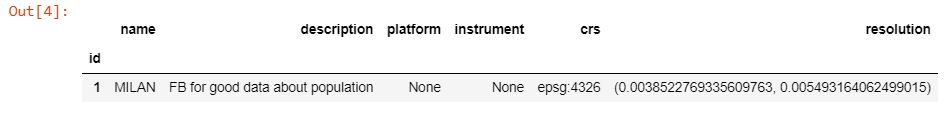

In [ ]:
# Select a specific product and show it's measurements
product = 'MILAN'
measurements = dc.list_measurements()
measurements.loc[product]

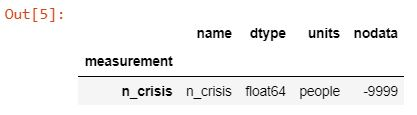

# Loading data

In [ ]:
# Creation of widgets that allow the user to select a time interval

import ipywidgets as widgets

day_options = []
for i in range(1,32,1):
    day_options.append(str(i))

month_options = []
for i in range(1,13,1):
    month_options.append(str(i))
day_options = pd.DataFrame(day_options, columns=['day'])
month_options = pd.DataFrame(month_options, columns=['month'])
year_options = ['2020', '2021']
year_options = pd.DataFrame(year_options, columns=['year'])

day = widgets.SelectMultiple(options=['---']+list(day_options['day'].unique()), description='Day:')
month = widgets.SelectMultiple(options=['---']+list(month_options['month'].unique()), description='Month:')
year = widgets.SelectMultiple(options=['---']+list(year_options['year'].unique()), description='Year:')

In [ ]:
print('Time Interval')
print('Select a year, month or specific day: ')

display(day, month, year)

In [ ]:
y = year.value[0]
m = month.value[0]
d = day.value[0]
time_range = y + '-' + m + '-' + d

In [ ]:
# The function dc.load allows to load all dataset from 'FB_POP_MILANO' that matches the given spatial and temporal extent
latitude_bounds = (45.311597470877999, 45.627484179430269)
longitude_bounds = (8.995056152343800, 9.549865722656120)
ds = dc.load(product='MILAN',
             time = '2020-4')

In [ ]:
print(ds)
print(type(ds))

In [ ]:
latitude_extents = (min(ds['latitude'].values),max(ds['latitude'].values))
longitude_extents = (min(ds['longitude'].values),max(ds['longitude'].values))
time_extents = (min(ds['time'].values),max(ds['time'].values))

In [ ]:
print(latitude_extents)
print(longitude_extents)
print(time_extents)

# Data plotting

# Plot of mean/variance/median over time

In [ ]:
# User through a widget selects an operator between mean, variance and median.
# The function 'plot_time-op' returns for each time the result of the chosen operator on the data ('n_crisis')
# Results of the function are returned as lists, in this example are plotted in a graph

options = ['Mean', 'Variance', 'Median']
df_options = pd.DataFrame(options, columns=['options'])

import ipywidgets as widgets
sel_operator = widgets.SelectMultiple(
    options=['---']+list(df_options['options'].unique()),
    description='Operator:'
)
display(sel_operator)

In [ ]:
operator = sel_operator.value[0]

In [ ]:
def plot_time_op(operator, ds):
    time_list = ds.time.to_dataframe()
    time_list = time_list['time'].tolist()
    y = []
    for i in time_list:
        df_i = ds.sel(time=i).to_dataframe()
        df_i = df_i.reset_index().replace(to_replace=-9999, value=0)
        if operator == 'Mean':
            mean_i = df_i['n_crisis'].mean()
            y.append(mean_i)
        elif operator == 'Variance':
            std_i = df_i['n_crisis'].std()
            y.append(std_i)
        elif operator == 'Median':
            med_i = df_i['n_crisis'].median()
            y.append(med_i)
    return [time_list, y]

In [ ]:
axes = plot_time_op(operator, ds)
x = axes[0]
y = axes[1]

title = operator + ' of people per time'
plt.title(title)
plt.xlabel('time')
plt.ylabel(operator)
plt.plot(x, y)
plt.show()

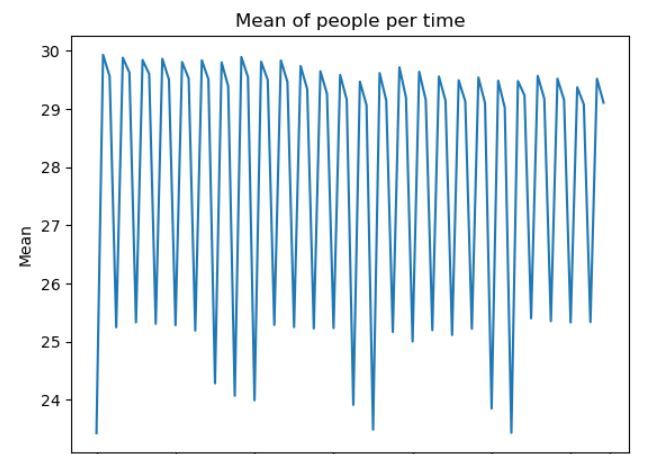

# Mean/variance/median of each point over time

In [ ]:
options = ['Mean', 'Variance', 'Median']
df_options = pd.DataFrame(options, columns=['options'])

import ipywidgets as widgets
sel_operator = widgets.SelectMultiple(
    options=['---']+list(df_options['options'].unique()),
    description='Operator:'
)
display(sel_operator)

In [ ]:
operator = sel_operator.value[0]

In [ ]:
# The following function allow to create a grid, each point of the grid contains the mean/variance/median of the registered value across time interval
def grid_of_op(operator, ds):
    lon_list = ds.longitude.to_dataframe()
    lon_list = lon_list['longitude'].tolist()
    lat_list = ds.latitude.to_dataframe()
    lat_list = lat_list['latitude'].tolist()
    
    grid_op = pd.DataFrame(columns = ['latitude', 'longitude', 'value'])
    for i in lat_list:
        for j in lon_list:
            df_i = ds.sel(longitude=j, latitude=i).to_dataframe().reset_index().replace(to_replace=-9999, value=0)
            if operator == 'Mean':
                val = df_i['n_crisis'].mean()
            elif operator == 'Variance':
                val = df_i['n_crisis'].std()
            elif operator == 'Median':
                val = df_i['n_crisis'].median()
            row = pd.DataFrame([[i, j, val]], columns = ['latitude', 'longitude', 'value'])
            grid_op = grid_op.append(row)
    return grid_op

In [ ]:
grid2 = grid_of_op(operator, ds)
grid2 = grid2.reset_index().drop(columns=['index'])

In [ ]:
df = grid2
title = operator + ' of people per time for each point'
fig = plt.scatter(x=df['longitude'], y=df['latitude'], marker = 'o', c = df['value'])
plt.title(title)
plt.show(fig)

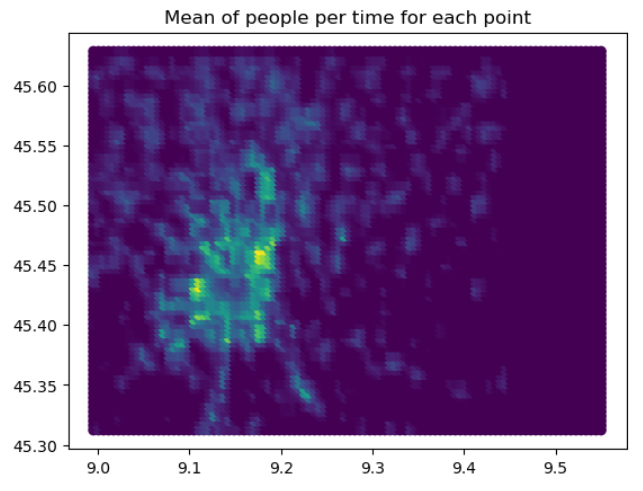

# Temporal analysis for a selected point

In [ ]:
# The user inserts the precise coordinates of a point, the function temporal_series extraxt from the dataset the number of people
# present in that point in the chosen time interval
lat_widg = widgets.FloatText(value='0.0', description='Latitude:')
lon_widg = widgets.FloatText(value='0.0', description='Longitude:')
display(lat_widg, lon_widg)

In [ ]:
lat = lat_widg.value
lon = lon_widg.value

In [ ]:
def temporal_series(ds, lat, lon):
    df = ds.sel(latitude=lat, longitude=lon).to_dataframe().reset_index()
    df = df[['time', 'n_crisis']]
    df = df.replace(to_replace=-9999, value=0)
    return df

In [ ]:
temp_df = temporal_series(ds, lat, lon)
x = temp_df['time']
y = temp_df['n_crisis']

title = 'Time series for point: ('+str(lat)+','+str(lon)+')'
plt.title(title)
plt.xlabel('time')
plt.ylabel('#people')
plt.plot(x, y)
plt.show()

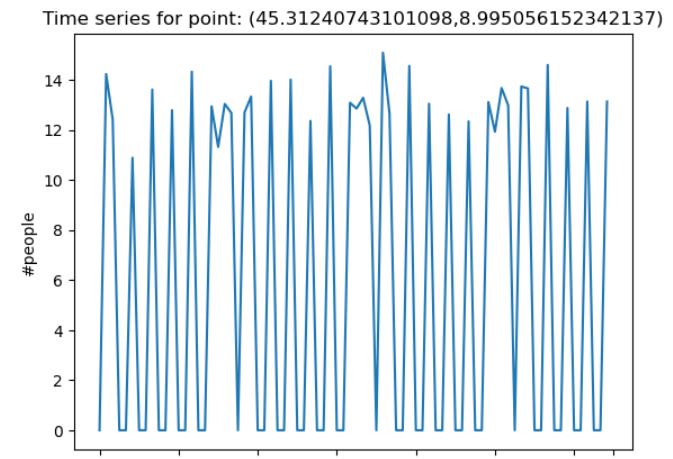